In [1]:
!nvidia-smi

Fri Aug  9 14:21:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

#import DataGenerator as DG
from DataGenerator import DataGenerator

import sklearn.metrics as metrics

import numpy as np
import random
import math
import os
import glob

import matplotlib.pyplot as plt

import h5py

In [3]:
###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
###Tensorflow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
depth = 10

In [24]:
model_files=["training-1098/model_progress_01.h5",
             "training-1098/model_progress_02.h5",
             "training-1098/model_progress_03.h5",
             "training-1098/model_progress_04.h5",
             "training-1098/model_progress_05.h5"]#["model-2019-07-26-20:21:18.h5",
#"model-2019-07-26-20:25:44.h5",
#"model-2019-07-26-20:36:01.h5",
#"model-2019-07-26-20:39:22.h5"]
use_single = False
single_model = "models/model-73-acc.h5"#"training-968/model_progress_01.h5"
#"model-2019-07-24-19:30:14.h5",
filepath = "images_synthetic_mouse.h5"

scratch_dir = "/mnt/disks/sec/Amit/"#"/n/scratch2/ap487/"
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  /mnt/disks/sec/Amit/images_synthetic_mouse.h5


In [6]:
def accuracy(predictions, answers, top_n=5):
    accs = np.zeros(len(answers))
    predicts = np.zeros(len(test_labels))
    for i in range(0,len(answers)):
        j = len(predictions[i])-1
        for k in range(0,top_n):
            if predictions[i][j-k]==answers[i]:
                accs[i]=1
                predicts[i]=predictions[i][j-k]
    return np.mean(accs), predicts

In [8]:
with h5py.File(filepath,'r') as f:
    amt = 70000
    print("Loading Test Data: " , amt)
    data_gen = DataGenerator(filepath,data_amount=amt,batch_size=int(math.floor(amt/depth)),frames_per_sample=depth,offset=800000,sliding_window=1)
    dat,lbl = data_gen.__getitem__(0)
    test_data=dat
    test_labels=lbl
    print("Test Data loaded")  

Loading Test Data:  70000
Test Data loaded


In [9]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX,verbose=1) for model in members]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

In [25]:
models = []
if use_single:
    models.append(keras.models.load_model(single_model))
else:
    for i in range(0, len(model_files)):
        models.append(keras.models.load_model(model_files[i]))

7000/7000 [==============================] - 25s 4ms/sample
0.635


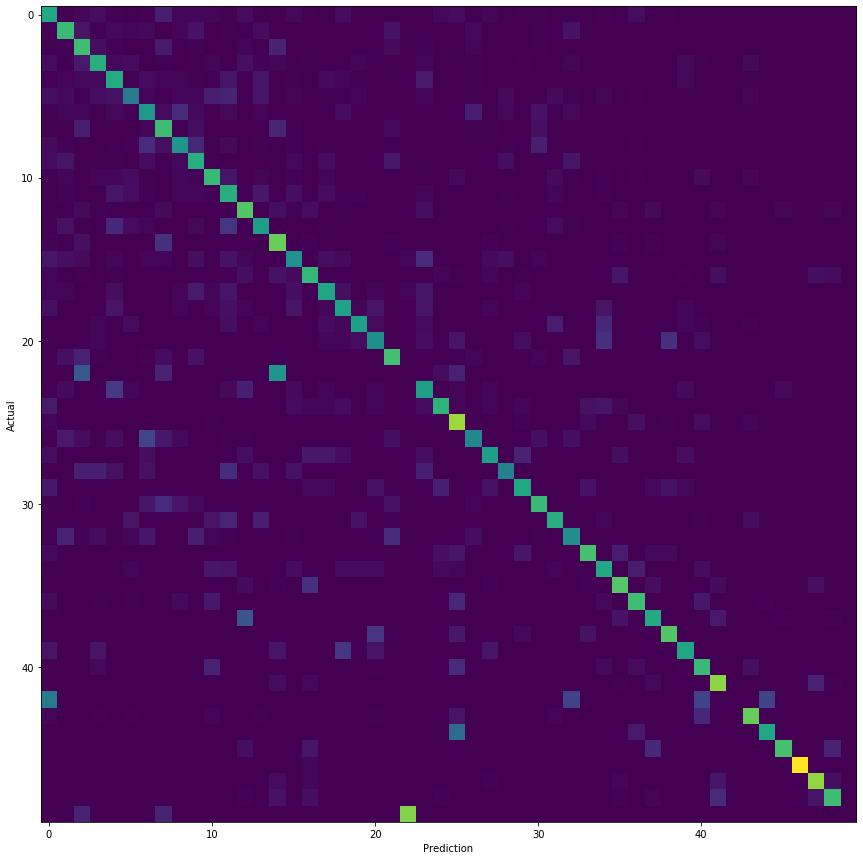

In [26]:
p=ensemble_predictions(models,test_data)
s = 0
for i in range(0,len(p)):
    if p[i]==test_labels[i]:
        s+=1
print(s/len(p))
conf_mat=metrics.confusion_matrix(test_labels,p)
conf_mat=conf_mat / conf_mat.astype(np.float).sum(axis=1,keepdims=True)
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(conf_mat)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [12]:
#model_benchmarks = np.load("benchmarks.npy")
#model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
#np.save("benchmarks.npy",model_benchmarks)
np.save("benchmarks/Ver2_1_Ensemble.npy",metrics.f1_score(test_labels,p,average=None))

/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


benchmarks/Ver1_2.npy 0.5838799963592192
benchmarks/Ver1_1.npy 0.5035154334506492
benchmarks/Ver2_1.npy 0.5850964680675242
benchmarks/Ver2_1_Ensemble.npy 0.5896001885516872


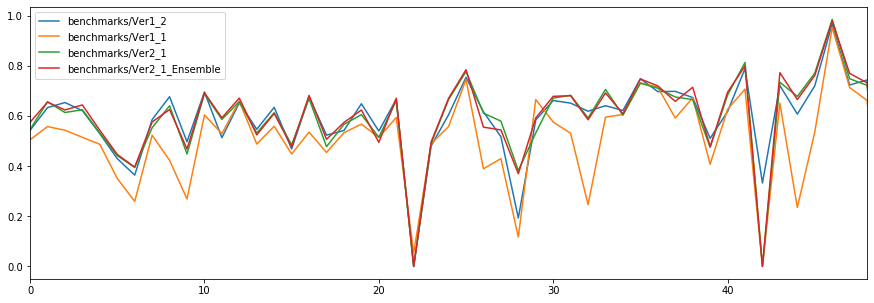

In [18]:
f1_paths = glob.glob("benchmarks/[!t23]*.npy")
plt.rcParams["figure.figsize"] = (15,5)
for path in f1_paths:
    print(path,np.mean(np.load(path)))
    plt.plot(np.load(path),label=path.split('.')[0])
plt.xlim(0,48)
plt.legend()
plt.show()

In [17]:
print(metrics.f1_score(test_labels,p,average=None))

[0.63304515 0.66894472 0.64937149 0.59936508 0.59215916 0.50403877
 0.61790581 0.64438356 0.49225754 0.6491063  0.68449728 0.61020093
 0.64979944 0.67173554 0.70071629 0.57694118 0.58853784 0.67217631
 0.69895432 0.7057072  0.72636263 0.66645669 0.28233151 0.64170616
 0.72123369 0.76871722 0.41629956 0.51218192 0.37625861 0.68643533
 0.64650956 0.64379947 0.30440967 0.82034771 0.66617321 0.76928983
 0.77303989 0.74889868 0.73215941 0.67352666 0.71544715 0.79731801
 0.0617284  0.68764045 0.4969697  0.58071279 0.95229603 0.76650682
 0.75846834 0.         0.         0.         0.         0.
 0.        ]


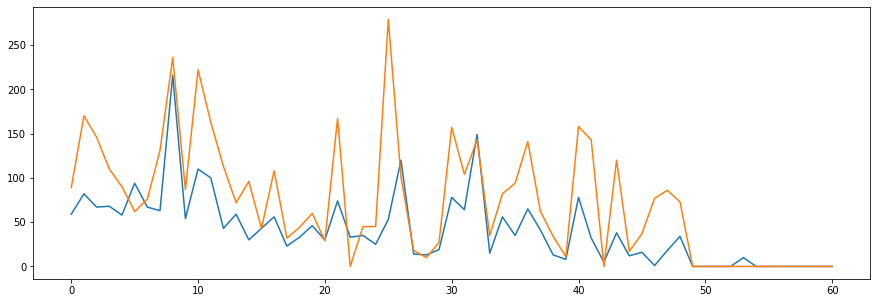

8


In [20]:
#u=np.unique(test_labels,return_counts=True)
u=np.zeros(61)#(len(np.unique(test_labels[:])))
t=np.zeros(61)
for i in range(0,len(p)):
    if not p[i]==test_labels[i]:
        x = test_labels[i]
        u[int(x)]+=1
    else:
        x = test_labels[i]
        t[int(x)]+=1
#plt.hist(u,60)
plt.plot(u)
plt.plot(t)
plt.show()
print(np.argmax(u))

In [1]:
!nvidia-smi 

Failed to initialize NVML: Driver/library version mismatch
